In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from scipy.spatial.distance import cdist


df=pd.read_feather("../../data/interim/work_school_home_sp_esc.feather")
df['id'] = df.index + 1

In [2]:
# FIND ZONE CENTERS

zones_centers = {}
for i in range(1, int(df.home.max()) + 1):
    tmp = df[df['work']==i][['work_x', 'work_y']]
    if len(tmp) > 0: 
        zones_centers[i] = (tmp['work_x'].mean(), tmp['work_y'].mean())

In [299]:
def get_pairs(arr, limit, edge_list, q, cutoff, x, y):
    dst = cdist(arr[[x, y]].values, arr[[x, y]].values, 'euclidean')
    df_dst = pd.DataFrame(dst)
    #qtl = np.quantile(df_dst.values.flatten(), q)
    qtl = q
    df_dst = df_dst.apply(lambda x: np.random.random() < (qtl - x)/qtl)   
    df_dst.index = arr['id']
    df_dst.columns = arr['id']
    for i,x in df_dst.iterrows():
        pairs = x[(x.values) & (x.index != i)].index.values
        pairs = [(i,p) for p in pairs if i < p]
        if len(pairs) > cutoff:
            pairs = np.array(pairs)[np.random.choice(len(pairs), size=cutoff, replace=False)]
            pairs = [(x,y) for x,y in pairs]
        edge_list.extend(pairs)
        
q = 50
cutoff = 20
school_edge_list = []
schools = df[['id', 'school_x', 'school_y']].dropna().copy()
s_kmeans = KMeans(n_clusters=len(zones_centers), init=np.array(list(zones_centers.values())))\
                .fit(schools.drop('id', axis=1).values)
schools['outer_cluster'] = s_kmeans.labels_
schools.groupby('outer_cluster').apply(get_pairs, limit=cutoff, edge_list=school_edge_list, 
                                       q=q, cutoff=cutoff, x='school_x', y='school_y')
print(len(school_edge_list))


q = 25
cutoff = 5
neighbor_edge_list = []
neighbor = df[['id', 'home_x', 'home_y']].dropna().copy()
s_kmeans = KMeans(n_clusters=len(zones_centers), init=np.array(list(zones_centers.values())))\
                .fit(neighbor.drop('id', axis=1).values)
neighbor['outer_cluster'] = s_kmeans.labels_
neighbor.groupby('outer_cluster').apply(get_pairs, limit=cutoff, edge_list=neighbor_edge_list, 
                                       q=q, cutoff=cutoff, x='home_x', y='home_y')
print(len(neighbor_edge_list))


q = 100
cutoff = 15
work_edge_list = []
works = df[['id', 'work_x', 'work_y']].dropna().copy()
w_kmeans = KMeans(n_clusters=len(zones_centers), init=np.array(list(zones_centers.values())))\
                .fit(works.drop('id', axis=1).values)
works['outer_cluster'] = w_kmeans.labels_
works.groupby('outer_cluster').apply(get_pairs, limit=cutoff, edge_list=work_edge_list,
                                     q=q, cutoff=cutoff, x='work_x', y='work_y')
print(len(work_edge_list))

c:\users\paola\anaconda3\envs\cmdp\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


42947


c:\users\paola\anaconda3\envs\cmdp\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


88086


c:\users\paola\anaconda3\envs\cmdp\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


48371


In [300]:
works_edges = pd.DataFrame(work_edge_list, columns=['source', 'target'])
works_edges['edge_type'] = 'work'

print("Shape works: ", works_edges.shape)

schools_edges = pd.DataFrame(school_edge_list, columns=['source', 'target'])
schools_edges['edge_type'] = 'school'

print("Shape schools: ", schools_edges.shape)


homes = pd.merge(df[['home_id', 'id', 'home']], df[['home_id', 'id', 'home']], 
         on=['home_id', 'home'], how='inner').query('id_x != id_y').astype(int)

home_edges = homes[['id_x', 'id_y']].copy()
home_edges['edge_type'] = 'home'
home_edges = home_edges.rename(columns= {'id_x': 'source', 'id_y': 'target'})
home_edges = home_edges[home_edges['source'] < home_edges['target']]

print("Shape home: ", home_edges.shape)

neighbor_edges = pd.DataFrame(neighbor_edge_list, columns=['source', 'target'])
neighbor_edges['edge_type'] = 'neighbor'
neighbor_edges_not_home = pd.merge(pd.merge(neighbor_edges, df[['id', 'home_id']].rename({'id':'source'}, axis=1),
                                                            on='source', how='inner'),
                                            df[['id', 'home_id']].rename({'id':'target'}, axis=1),
                                                            on='target', how='inner').query('home_id_x != home_id_y')
neighbor_edges_not_home = neighbor_edges_not_home.drop(columns=['home_id_x', 'home_id_y'])
print("Shape Neighbor:  ", neighbor_edges_not_home.shape)

edge_list = pd.concat([works_edges, schools_edges, home_edges, neighbor_edges_not_home])

print("Shape Concat: ", edge_list.shape)
edge_list = edge_list[edge_list['source'] < edge_list['target']].drop_duplicates()
print("Shape final: ", edge_list.shape)

G = nx.from_pandas_edgelist(edge_list, edge_attr=True, create_using=nx.MultiGraph)

Shape works:  (48371, 3)
Shape schools:  (42947, 3)
Shape home:  (61634, 3)
Shape Neighbor:   (29108, 3)
Shape Concat:  (182060, 3)
Shape final:  (182060, 3)


In [301]:
df[['home', 'home_id', 'work', 'school', 'id']].dropna().head(50)

,home,home_id,work,school,id
1,1.0,00010001,82.0,84.0,2
12,1.0,00010009,79.0,23.0,13
24,1.0,00010018,153.0,53.0,25
26,1.0,00010020,1.0,24.0,27
29,1.0,00010024,1.0,61.0,30
34,1.0,00010027,4.0,24.0,35
35,1.0,00010027,1.0,24.0,36
39,1.0,00010031,144.0,23.0,40
47,1.0,00010039,27.0,24.0,48
91,1.0,00010718,24.0,86.0,92


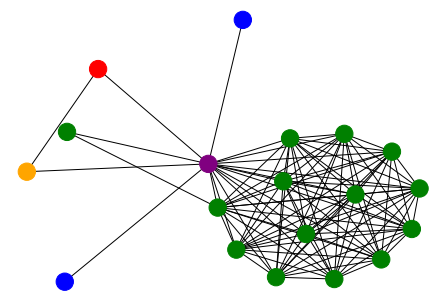

In [306]:
ego = 30
ego_net = nx.ego_graph(G, ego, radius=1)
ego_values = dict(df[df.id == ego][['home', 'home_id', 'work', 'school']].to_dict(orient='records')[0])
colors = ['purple' if n == ego else
          'red' if df[df.id == n].iloc[0]['home_id'] == ego_values['home_id'] else
          'blue' if df[df.id == n].iloc[0]['work'] == ego_values['work'] else 
          'green' if df[df.id == n].iloc[0]['school'] == ego_values['school'] else
          'orange' if df[df.id == n].iloc[0]['home'] == ego_values['home'] else
          'gray' for n in ego_net]
nx.draw_kamada_kawai(ego_net, node_color = colors, with_labels=False)

In [316]:
node_data = df[['home', 'school', 'work', 'id', 'idade']]\
            .rename({'idade': 'age'}, axis=1).set_index('id').to_dict(orient='index')

In [318]:
nx.set_node_attributes(G, node_data)

In [323]:
nx.write_gpickle(G, '../../data/processed/multiGraph_prob_dist.gpickle')

In [303]:
df[df.id.isin([24161, 39514, 681])]

,home,school,work,id,work_x,work_y,school_x,school_y,home_x,home_y,home_id,idade,criteriobr,renda_fa,education,job_level,studies,private_healthcare
680,7.0,79.0,59.0,681,333934.0,7386971.0,330710.0,7393408.0,333433.0,7396262.0,00070840,33.0,NaN,4050.339321,5.0,2.0,5.0,True
24160,144.0,NaN,250.0,24161,333955.0,7386914.0,NaN,NaN,332588.0,7402398.0,01441547,36.0,3.0,3391.406462,4.0,2.0,1.0,False
39513,254.0,NaN,250.0,39514,333974.0,7386895.0,NaN,NaN,338643.0,7391152.0,02540032,22.0,3.0,7500.000000,4.0,2.0,1.0,True


In [304]:
sorted(list(map(len, list(nx.connected_components(G)))), reverse=True)

[41586,
 30,
 26,
 24,
 23,
 20,
 20,
 18,
 18,
 18,
 17,
 15,
 15,
 15,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5

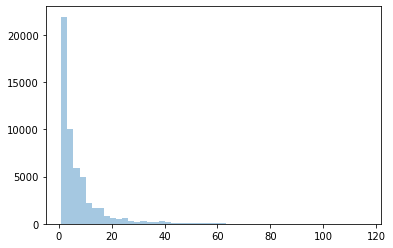

In [242]:
sns.distplot(list(dict(G.degree).values()), kde=False);

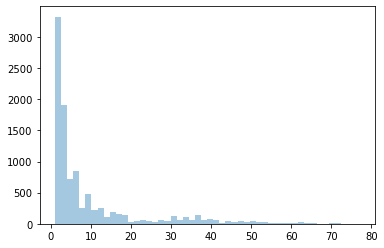

In [243]:
sns.distplot(list(dict(nx.from_pandas_edgelist(schools_edges).degree).values()), kde=False);

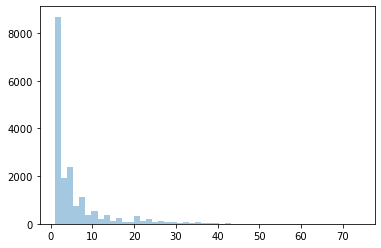

In [244]:
sns.distplot(list(dict(nx.from_pandas_edgelist(works_edges).degree).values()), kde=False);

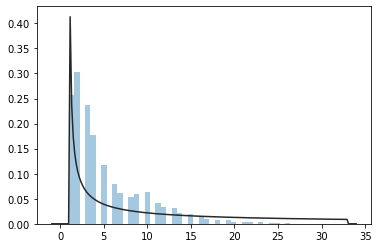

In [251]:
sns.distplot(list(dict(nx.from_pandas_edgelist(neighbor_edges_not_home).degree).values()), kde=False, fit=powerlaw);

In [248]:
len(max(list(nx.connected_components(G)), key=len))

41500

In [56]:
threshold = 100

def closest_people(p):
    distances = list(map(np.linalg.norm, np.array(p[['work_x', 'work_y']].values) - df[['work_x', 'work_y']].values))
    distances = np.array(distances)
    distances = distances < threshold
    close = list(itertools.compress(range(len(distances)), distances))
    return close


neighbors = df.apply(closest_people, axis=1)

c:\users\paola\anaconda3\envs\cmdp\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


array([[ 333104, 7394476],
       [ 327503, 7392159],
       [ 333453, 7394501],
       ...,
       [ 323653, 7391801],
       [ 323034, 7390476],
       [ 326770, 7387716]])

In [66]:
def all_pairs_euclid_numpy(A, B):
    #
    sqrA = np.broadcast_to(np.sum(np.power(A, 2), 1).reshape(A.shape[0], 1), (A.shape[0], B.shape[0]))
    sqrB = np.broadcast_to(np.sum(np.power(B, 2), 1).reshape(B.shape[0], 1), (B.shape[0], A.shape[0])).transpose()
    #
    return np.sqrt(
        sqrA - 2*np.matmul(A, B.transpose()) + sqrB
    )


In [70]:
work_coords = df[['work_x', 'work_y']].values.astype(int)
new_neighs = all_pairs_euclid_numpy(work_coords, work_coords)

c:\users\paola\anaconda3\envs\cmdp\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


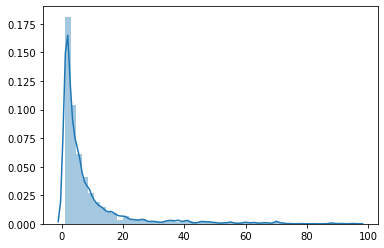

In [60]:
import seaborn as sns
len_neigh = np.array(list(map(len, neighbors)))
sns.distplot(len_neigh[len_neigh > 0])

In [125]:
def chance_of_connection(distance, K=-1):
    return 1 / (1 + np.exp(distance*K))

In [126]:
arr = np.array(list(map(chance_of_connection, new_neighs[0])))
len(arr[arr>0.5])

c:\users\paola\anaconda3\envs\cmdp\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


26980

In [133]:
from scipy.special import expit

def normallize_to_range(x,  x_min, x_max, scale=1, a=-6, b=6):
    x = (x - x_min)/(x_max - x_min)
    x = (x*(b-a)) + a
    return x

def chance_to_connect(d, limit=100, scale=1):
    y = expit(normallize_to_range(d, 0, limit, scale))
    return 1 - y*scale

In [232]:
np.sum(np.isnan(new_neighs[5]))

13314

In [224]:
sthocastic_neighbors = np.array(list(map(chance_to_connect, new_neighs[:20, :]))) > np.random.random()
[np.sum(x) for x in sthocastic_neighbors]

c:\users\paola\anaconda3\envs\cmdp\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


[35,
 13,
 3,
 1,
 1,
 28491,
 9,
 5,
 28491,
 5,
 28491,
 1,
 2,
 28491,
 28491,
 28491,
 28491,
 2,
 28491,
 12]

In [141]:
new_neighs.shape

(55492, 55492)

In [140]:
np.sum(np.array(list(map(chance_to_connect, new_neighs))) > 0.5)


KeyboardInterrupt: 

In [21]:
df[['home_x', 'home_y']].values

array([[ 333743., 7394463.],
       [ 333743., 7394463.],
       [ 333814., 7394428.],
       ...,
       [ 322857., 7390956.],
       [ 323034., 7390476.],
       [ 323034., 7390476.]])

In [22]:
[[x,y]]*len(df)

[[333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394476.0],
 [333104.0, 7394

[0.0,
 0.0,
 79.1580697086532,
 79.1580697086532,
 79.1580697086532,
 79.1580697086532,
 90.0222194794152,
 90.0222194794152,
 0.0,
 82.76472678623425,
 82.76472678623425,
 0.0,
 0.0,
 0.0,
 81.39410298049853,
 94.81033698917012,
 94.81033698917012,
 122.03687967167957,
 122.03687967167957,
 90.0222194794152,
 90.0222194794152,
 79.1580697086532,
 79.1580697086532,
 79.1580697086532,
 79.1580697086532,
 32.55764119219941,
 32.55764119219941,
 32.55764119219941,
 108.81176406988355,
 36.05551275463989,
 36.05551275463989,
 294.45033537083975,
 294.45033537083975,
 294.45033537083975,
 294.45033537083975,
 294.45033537083975,
 294.45033537083975,
 919.8070449828051,
 919.8070449828051,
 919.8070449828051,
 919.8070449828051,
 244.1679749680535,
 244.1679749680535,
 244.1679749680535,
 693.9920748827035,
 693.9920748827035,
 693.9920748827035,
 919.8070449828051,
 919.8070449828051,
 919.8070449828051,
 294.45033537083975,
 294.45033537083975,
 919.8070449828051,
 919.8070449828051,
 693.

In [2]:
def clusterize_relation(df, relation_name='home', x_coord='home_x', y_coord='home_y',
                            new_col_name = 'Neighbourhood', n_participants = 10, 
                            category_column = None, seed=13):
    data = []
    means = []
       
    for zone in df[relation_name].unique():
        if pd.notna(zone):
            if category_column is not None:
                tmp = df[df[relation_name] == zone][['id', x_coord, 
                                                 y_coord, relation_name,
                                                 category_column]].copy()
            else:
                tmp = df[df[relation_name] == zone][['id', x_coord, 
                                                 y_coord, relation_name]].copy()
            
            n_clusters = int(np.sum(len(tmp)) / n_participants)
 
            if n_clusters < 2:
                tmp[new_col_name] = (tmp[relation_name].astype(int).astype(str)
                                     + '_' + '0')
            else: 
                X = tmp[[x_coord, y_coord]]
                kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(X)
                tmp[new_col_name] = kmeans.labels_
                
                if relation_name == 'school':
                    v = tmp[category_column].dropna().value_counts().sort_index().index
                    p = tmp[category_column].dropna().value_counts().sort_index().values
                    p = p/np.sum(p)
                    tmp[category_column].fillna(np.random.choice(v, p=p), inplace=True)
                
                
                if category_column is not None:
                    tmp[new_col_name] = (tmp[relation_name].astype(int).astype(str) + '_'
                                     + tmp[new_col_name].astype(int).astype(str) + '_'
                                     + tmp[category_column].astype(int).astype(str))
                else:
                    tmp[new_col_name] = (tmp[relation_name].astype(int).astype(str) + '_'
                                     + tmp[new_col_name].astype(int).astype(str))
            
            data.append(tmp)
                
    final = pd.concat(data)

    return final

def make_clusters(df, home_cluster_n=10, work_cluster_n=20, school_cluster_n=30):
    df = df.copy()   
    
    home_clusters = clusterize_relation(df,'home', 'home_x', 'home_y', 'home_cluster',
                                        home_cluster_n, None)
    
    work_clusters = clusterize_relation(df,'work', 'work_x', 'work_y', 'work_cluster',
                                        work_cluster_n, None)
    
    school_clusters = clusterize_relation(df,'school', 'school_x', 'school_y',
                                          'school_cluster', school_cluster_n,
                                          'studies')

    return merge_cluster_dataframes(df, home_clusters, work_clusters, school_clusters)

def merge_cluster_dataframes(df, home_clusters, work_clusters, school_clusters):
    merged = pd.merge(df, home_clusters.drop(['home_x', 'home_y'], axis=1), 
                                             on=['id', 'home'], how='left')
    
    merged = pd.merge(merged, work_clusters.drop(['work_x', 'work_y'], axis=1),
                                                 on=['id', 'work'], how='left')
    
    merged = pd.merge(merged, school_clusters.drop(['school_x', 'school_y', 
                                                    'studies'], axis=1), 
                                                   on=['id', 'school'], how='left')
    
    assert merged[merged['home'].notna()]['home_cluster'].isna().sum() == 0

    assert np.sum([(merged['work'].notna()) 
            & (merged['work_cluster'].isna()
            & (merged['job_level'] != -1))]) == 0
    
    assert np.sum([((merged['school'].notna()) | (merged['job_level'] == -1)) 
            & (merged['school_cluster'].isna())]) == 0
    
    return merged

In [3]:
df = make_clusters(df, 10, 20, 30)

In [4]:
df

,home,school,work,id,work_x,work_y,school_x,school_y,home_x,home_y,...,idade,criteriobr,renda_fa,education,job_level,studies,private_healthcare,home_cluster,work_cluster,school_cluster
0,1.0,NaN,3.0,1,333104.0,7394476.0,NaN,NaN,333743.0,7394463.0,...,59.0,4.0,2732.575910,3.0,2.0,1.0,False,1_1,3_0,NaN
1,1.0,84.0,82.0,2,327503.0,7392159.0,329431.0,7395939.0,333743.0,7394463.0,...,21.0,4.0,2732.575910,4.0,2.0,5.0,False,1_1,82_16,84_1_5
2,1.0,NaN,1.0,3,333453.0,7394501.0,NaN,NaN,333814.0,7394428.0,...,37.0,5.0,3200.000000,4.0,2.0,1.0,False,1_4,1_7,NaN
3,1.0,NaN,1.0,4,333539.0,7394387.0,NaN,NaN,333814.0,7394428.0,...,19.0,5.0,3200.000000,3.0,2.0,1.0,False,1_4,1_7,NaN
4,1.0,NaN,26.0,5,332344.0,7393317.0,NaN,NaN,333814.0,7394428.0,...,18.0,5.0,3200.000000,3.0,2.0,1.0,False,1_4,26_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55487,342.0,NaN,90.0,55488,327737.0,7396374.0,NaN,NaN,323322.0,7392038.0,...,27.0,1.0,9461.630458,5.0,4.0,1.0,True,342_10,90_0,NaN
55488,342.0,NaN,341.0,55489,323653.0,7391801.0,NaN,NaN,322857.0,7390956.0,...,52.0,1.0,9461.630458,5.0,2.0,1.0,True,342_6,341_0,NaN
55489,342.0,NaN,341.0,55490,323653.0,7391801.0,NaN,NaN,322857.0,7390956.0,...,26.0,1.0,9461.630458,5.0,2.0,1.0,True,342_6,341_0,NaN
55490,342.0,NaN,342.0,55491,323034.0,7390476.0,NaN,NaN,323034.0,7390476.0,...,28.0,3.0,3000.000000,5.0,2.0,1.0,False,342_3,342_1,NaN


In [5]:
def add_person_to_graph(G, person):
    G.add_node(person['id'],
               work = person['work'],
               school = person['school'],
               home = person['home'],
               job_level = person['job_level'],
               education = person['studies'],
               age = person['idade'],
               private_healthcare = person['private_healthcare'],
               home_id = person['home_id'],
               home_x= person['home_x'], home_y = person['home_y'], 
               school_x = person['school_x'], school_y = person['school_y'],
               work_x = person['work_x'], work_y = person['work_y'],
               criterio_br = person['criteriobr'] )    

def add_people_to_graph(G, df):
    print('Adding People Nodes')
    df.apply(lambda x: add_person_to_graph(G, x), axis=1)
    print(25*'*')

def add_edge(G, person1, person2, edge_type, relation_cluster, edge_zone):
    G.add_edge(person1, person2, edge_type=edge_type,
               cluster=relation_cluster, zone=edge_zone)

def add_edges(G, df, relation, cluster, edge_type):
    print(f'Adding {edge_type} Edges')
    total_edges = 0
    for c in tqdm(df[cluster].unique()):
        if pd.notna(c):
            tmp = df[df[cluster] == c]
            assert len(np.unique(tmp[relation])) == 1
            zone = tmp[relation].iloc[0]
            if len(tmp) > 1:
                combinations = list(itertools.combinations(tmp['id'].values, 2))
                total_edges += len(combinations)
                for p1, p2 in combinations:
                    add_edge(G,p1, p2, edge_type, c, zone)
   
    print(len([True for x,y,v in G.edges.data(data=True) if v['edge_type'] == edge_type]))
    print(25*'*')
    return total_edges

In [6]:
G = nx.MultiGraph()
add_people_to_graph(G, df)
houses = add_edges(G, df, 'home', 'home_id', 'home')
neighbors = add_edges(G, df, 'home', 'home_cluster', 'neighbor')
works = add_edges(G, df, 'work',   'work_cluster', 'work')
schools = add_edges(G, df, 'school', 'school_cluster', 'school')
assert len(G.nodes()) == len(df)
assert houses == len([True for x,y,v in G.edges.data(data=True) if v['edge_type'] == 'home'])
assert neighbors == len([True for x,y,v in G.edges.data(data=True) if v['edge_type'] == 'neighbor'])
assert works == len([True for x,y,v in G.edges.data(data=True) if v['edge_type'] == 'work'])
assert schools == len([True for x,y,v in G.edges.data(data=True) if v['edge_type'] == 'school'])


Adding People Nodes


  0%|▏                                                                             | 52/21708 [00:00<01:23, 258.22it/s]

*************************
Adding home Edges


  0%|▍                                                                              | 26/5401 [00:00<00:21, 250.39it/s]

61634
*************************
Adding neighbor Edges


  2%|█▍                                                                             | 21/1201 [00:00<00:05, 205.26it/s]

348835
*************************
Adding work Edges


  3%|██▍                                                                             | 22/734 [00:00<00:03, 218.32it/s]

342525
*************************
Adding school Edges


100%|███████████████████████████████████████████████████████████████████████████████| 734/734 [00:03<00:00, 219.94it/s]


209044
*************************


In [7]:
df.to_feather("../../data/processed/clusterized_df.feather")

In [8]:
nx.write_gpickle(G, '../../data/processed/SP_multiGraph_Job_Edu_Level.gpickle')

In [14]:
len([True for g,d in G.nodes(data=True)  if pd.notna(d['school']) ])

12605